In [1]:

import numpy as np
import math
import pandas as pd
import random
import seaborn as sn

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from tensorflow.keras import losses
from keras.preprocessing.image import load_img, save_img, img_to_array


from PIL import Image
import pickle
from google.colab import files
from google.colab import drive
import gc



from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.utils import shuffle
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

                
import os
import sys

In [2]:
#utility class to improve the readability of the output texts
class output:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    END = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

###Program settings

In [3]:
                           ####################
############################ RUNNING SETTINGS ############################
                           ####################

#Eneble the debug messages:
DEBUG_MODE = True 

#Use google drive as local memory
GOOGLE_DRIVE = True

                           ####################                                  
############################ DATASET SETTINGS ############################
                           #################### 

#Use the dataset already created before => faster exectution of the code: 
#set it to true if you want use the default dataset 
#(with 7000 samples for train and 3000 samples for test):                              
DATASETS_ALREADY_CREATED = True
                                  
#Download the datasets just computed in the local memory:
DOWNLOAD_DATASET = False

#Number of images to be used for the training phase:
IMAGES_TRAIN = 7000

#Number of images to be used for the training phase:
IMAGES_TEST = 3000


                           ##################
############################ MODEL SETTINGS ##############################
                           ##################

####################
# ISOLATION FOREST #
####################

#Select the number of estimators in the isolation forest model
N_ESTIMATORS = 50

#Load the already fitted isolation forest model:
LOAD_IF = True

#Load the already computed isolation forest model result:
LOAD_IF_RESULTS =  True

#Download the results obtained by the model in the local memory:
DOWNLOAD_RESULTS_IF = False

#Download the fitted model in the local memory:
DOWNLOAD_IF_MODEL = False

#######
# SVM #
#######

#Load the already fitted one-class SVM model (with SGD):
LOAD_SVM =  True

#Use stochastics gradient descent to train the SVM model 
SGD_SVM = True

#Load the already computed one-class SVM model result:
LOAD_SVM_RESULTS = True

#Download the results obtained by the model:
DOWNLOAD_RESULTS_SVM = False

#Download the fitted model in the local memory:
DOWNLOAD_SVM_MODEL = False

###############
# Autoencoder #
###############

#Select the number of epochs perfomed during the train phase:
N_EPOCHS = 100

#Select the batch size during the train phase:
BATCH_SIZE = 32

#Load the already fitted autoencoder:
LOAD_AUTOENCODER = True

#Load the already computed autoencoder result:
LOAD_AUTOENCODER_RESULTS = True

#Download the results obtained by the model:
DOWNLOAD_RESULTS_AUTOENCODER = False

#Download the fitted model in the local memory:
DOWNLOAD_AUTOENCODER_MODEL = False

##################
# CLASSIFICATION #
##################

#Select the number of epochs perfomed during the train phase:
N_EPOCHS_C = 100

#Select the batch size during the train phase:
BATCH_SIZE_C = 32

#Load the already fitted classificator:
LOAD_CLASSIFICATOR = True

#Download the fitted model in the local memory:
DOWNLOAD_CLASSIFICATOR_MODEL = False

In [5]:
if(GOOGLE_DRIVE):
  
  drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


 ### Downloading of the pre-computed datasets

In [6]:
#use the precomputed datasets
if(DATASETS_ALREADY_CREATED):

  #fixing the number of samples
  IMAGES_TRAIN = 7000
  IMAGES_TEST = 3000

  !gdown --id 18LgmmOYoJsiaf2-fiKFa0qtvNpUrxVOZ #X_train.npy
  X_train_vector = np.load("X_train.npy", mmap_mode = "r")

  !gdown --id 1WVgrwRu_A5KL5H2fAqDGxacbFcGbR7l5 #X_train_classification.npy
  !gdown --id 100qBozj2WQMbr90MSSBYliHmJneTgE4R #Y_train_classification.npy
  X_train_classification = np.load("X_train_classification.npy", mmap_mode = "r")
  Y_train_classification = np.load("Y_train_classification.npy", mmap_mode = "r")


  !gdown --id 1HKkuNT_HZnHbqmWpSsuNlHM8qRleITIm #X_test.npy
  !gdown --id 1BEOIBa50i9DDKPMSQWJMSfzlqZ3AU4-2 #Y_test.npy
  X_test_vector = np.load("X_test.npy", mmap_mode = "r")
  Y_test=np.load("Y_test.npy",mmap_mode = "r")

  !gdown --id 15rOBB22BfuYzal6wDg8EJQbXXs2FgXX5 #X_train_matrix.npy
  !gdown --id 1lbTIbg-Z2A04VfxujVhZfToDIm8Fa07r #X_test_matrix.npy
  X_train_matrix = np.load("X_train_matrix.npy", mmap_mode = "r")
  X_test_matrix=  np.load("X_test_matrix.npy",mmap_mode = "r")

  print(output.OKGREEN+str(len(X_train_vector))+" images loaded for the train set"+output.END)
  print(output.OKGREEN+str(len(X_test_vector))+" images loaded for the test set"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18LgmmOYoJsiaf2-fiKFa0qtvNpUrxVOZ
To: /content/X_train.npy
100% 459M/459M [00:01<00:00, 247MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WVgrwRu_A5KL5H2fAqDGxacbFcGbR7l5
To: /content/X_train_classification.npy
100% 1.84G/1.84G [00:06<00:00, 265MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading..

###Setting up the training set

In [7]:
#### DOWNLOAD OF THE TRAIN SET ####

if(not DATASETS_ALREADY_CREATED): #download the full dataset

  !gdown --id 1xfh_edTic07EGyFeI98O8FoCKkdQ5de4 #train.npz
  

In [8]:
if(not DATASETS_ALREADY_CREATED):
  #unzip the train dataset and delete the compressed folder
  
  !unzip train.npz
  !rm train.npz

In [9]:
if(not DATASETS_ALREADY_CREATED):

  #read the dataset: each picture is seen as a vector of lenght 65536 
  X_train_temp = np.load("arr_0.npy", mmap_mode = "r")

  print(output.OKGREEN+str(X_train_temp.shape[0])+" images loaded for the train set "+output.END)

  IMAGES_TRAIN = min(IMAGES_TRAIN, X_train_temp.shape[0])  # i can not add more images than the images avaiable

  print(output.WARNING+"Only "+str(IMAGES_TRAIN)+" images will be used"+output.END)



############## TRAIN SET FOR ANOMALY DETECTION #################

  #generation of the accepted indexes and sorting them
  indexes = random.sample(range(X_train_temp.shape[0]), IMAGES_TRAIN)
  indexes.sort()

  X_train_vector = X_train_temp[indexes]


  #convert the array into a memory-map array
  np.save("X_train", X_train_vector)

  #cleaning ram
  del X_train_vector
  gc.collect()

  X_train_vector = np.load("X_train.npy", mmap_mode = "r+")



#### DEBUG ####

if(DEBUG_MODE):

  print(output.BOLD+"\n\nCHECK"+output.END)

  if (len(X_train_vector) != IMAGES_TRAIN):

    print(output.WARNING+"\nERROR: Number of samples: "+str(len(X_train_vector))+" but "+str(IMAGES_TRAIN)+" were expected"+output.END)

  else:

    print(output.OKGREEN+"\nNumber of samples: "+str(len(X_train_vector)))

  if("(65536,)" == str(X_train_vector[0].shape)):

    print(output.OKGREEN+"Shape of vector samples: "+str(X_train_vector[0].shape)+output.END)
    
  else:
    
    print(output.WARNING+"ERROR: Shape of vector samples: "+str(X_train_vector[0].shape)+" but (65536,) was expected"+output.END)  



CHECK

Number of samples: 7000
Shape of vector samples: (65536,)


### Setting up the test set and train set for the classification module

In [10]:
#### DOWNLOAD OF THE TEST SET ####
if(not DATASETS_ALREADY_CREATED):
  
  !gdown --id 1uxwI0AUewcH67c2h17lB-9IOV4Ag5T-d #test.npz
  !gdown --id 1cVDr4Uv4jaiyYl4NS1yTiutxrjzCn0NS #test.csv

In [11]:
if(not DATASETS_ALREADY_CREATED):

  #remove the .npy file created for the train set in order to avoid that the program asks what to do with the new arr_0.npy file
  !rm arr_0.npy
  
  #unzip the test dataset and delete the compressed folder
  !unzip test.npz
  !rm test.npz

In [12]:
if(not DATASETS_ALREADY_CREATED):

  #read the dataset: each picture is seen as a vector of length 65536
  X_test_temp = np.load("arr_0.npy", mmap_mode = "r")

  print(output.OKGREEN+str(X_test_temp.shape[0])+" images loaded for the test set"+output.END)

  IMAGES_TEST = min(IMAGES_TEST, X_test_temp.shape[0])  # i can not add more images than the images avaiable

  print(output.WARNING+"Only "+str(IMAGES_TEST)+" images will be used"+output.END)


############## TRAIN SET FOR CLASSIFICATION #################  


  #generation of the accepted indexes and sorting them
  indexes = random.sample(range(X_test_temp.shape[0]), IMAGES_TRAIN)
  indexes.sort()

  X_train_classification = X_test_temp[indexes].reshape(IMAGES_TRAIN,256,256,1).astype("float32")

  Y_train_classification = pd.read_csv("test.csv")["fine_labels"].to_numpy()[indexes]

  #convert the 2 lists into 2 memory-map arrays

  np.save("X_train_classification", X_train_classification)

  #cleaning ram
  del X_test_vector
  gc.collect()

  X_train_classification = np.load("X_train_classification.npy", mmap_mode = "r+")


  np.save("Y_train_classification", Y_train_classification)

  #cleaning ram
  del Y_test
  gc.collect()


  Y_train_classification = np.load("Y_train_classification.npy", mmap_mode = "r+")


############## TEST SET #################  


  #generation of the accepted indexes and sorting them
  indexes = random.sample(range(X_test_temp.shape[0]), IMAGES_TEST)
  indexes.sort()

  X_test_vector = X_test_temp[indexes]#traintest split!

  Y_test = pd.read_csv("test.csv")["fine_labels"].to_numpy()[indexes]

  #convert the 2 lists into 2 memory-map arrays

  np.save("X_test", X_test_vector)

  #cleaning ram
  del X_test_vector
  gc.collect()

  X_test_vector = np.load("X_test.npy", mmap_mode = "r+")


  np.save("Y_test.npy", Y_test)

  #cleaning ram
  del Y_test
  gc.collect()


  Y_test = np.load("Y_test.npy", mmap_mode = "r+")



#### DEBUG ####
if(DEBUG_MODE):

  print(output.BOLD+"\n\nCHECK"+output.END)

  if (len(X_test_vector) != IMAGES_TEST):

    print(output.WARNING+"\nERROR: Number of samples: "+str(len(X_test_vector))+" but "+str(IMAGES_TEST)+" were expected"+output.END)

  else:

    print(output.OKGREEN+"\nNumber of samples: "+str(len(X_test_vector)))

  if("(65536,)" == str(X_test_vector[0].shape)):

    print(output.OKGREEN+"Shape of samples: "+str(X_test_vector[0].shape)+output.END)

  else:

    print(output.WARNING+"ERROR: Shape of samples: "+str(X_test_vector[0].shape)+" but (65536,) was expected"+output.END)



  print("\nNumber of images = number of labels?")

  if(len(X_test_vector) == len(Y_test)):

    print(output.OKGREEN+"YES"+output.END)

  else:
    
    print(output.WARNING+"NO"+output.END)



CHECK

Number of samples: 3000
Shape of samples: (65536,)

Number of images = number of labels?
YES


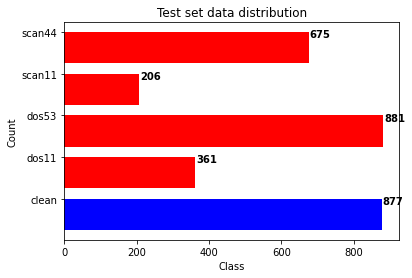

In [13]:
x = ["clean","dos11","dos53","scan11","scan44"]
y = np.unique(Y_test, return_counts=True)[1]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color=["blue","red","red","red", "red"])
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title("Test set data distribution")
plt.xlabel("Class")
plt.ylabel("Count")      
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color="black", fontweight="bold")
plt.savefig(os.path.join("test.png"), dpi=300, format="png", bbox_inches="tight")

###Cleaning and download






In [14]:
if(DOWNLOAD_DATASET):

  if(GOOGLE_DRIVE):

    !cp X_train.npy /content/drive/MyDrive
    !cp X_train_classification.npy /content/drive/MyDrive
    !cp Y_train_classification.npy /content/drive/MyDrive
    !cp X_test.npy /content/drive/MyDrive
    !cp Y_test.npy /content/drive/MyDrive

  else:
    
    files.download("X_train.npy")
    files.download("X_train_classification.npy")
    files.download("Y_train_classification.npy")
    files.download("Y_test.npy")
    files.download("X_test.npy")

  print(output.OKGREEN+"Datasets downloaded to local memory"+output.END)
  

In [15]:
#delete unused folder and file
!rm arr_0.npy
!rm Y_test.npy
!rm X_test.npy
!rm X_train.npy
!rm X_train_classification.npy
!rm Y_train_classification.npy

rm: cannot remove 'arr_0.npy': No such file or directory


##Isolation Forest module

###Generation of the model


In [16]:
if(not LOAD_IF): #if you don't want load a pre-computed model you need to generate it again

  print(output.UNDERLINE+str(N_ESTIMATORS)+" is the number of estimators selected"+output.END)

  IF_detector = IsolationForest(n_estimators = N_ESTIMATORS, 
                                n_jobs = -1, random_state = 2053042)
  
  IF_detector.fit(X_train_vector)

  with open("IF_model.pkl", "wb") as f:
    pickle.dump(IF_detector, f)
  print(output.OKGREEN+"Isolation forest model saved"+output.END)

else: #load the pre-computed model

  !gdown --id 1Rf6vDCYFLkDenPR63dCYmK4y4kJCgIJQ #IF_model.pkl

  with open("IF_model.pkl", "rb") as f:
    IF_detector = pickle.load(f)
  print(output.OKGREEN+"Isolation forest model loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Rf6vDCYFLkDenPR63dCYmK4y4kJCgIJQ
To: /content/IF_model.pkl
100% 26.3M/26.3M [00:00<00:00, 225MB/s]
Isolation forest model loaded


###Evaluation of the perfomace: training error and test error 

In [17]:
if(not LOAD_IF_RESULTS):

  Y_train_predicted = IF_detector.predict(X_train_vector)
  
  print(output.OKGREEN+"Isolation forest train results computed"+output.END)

else:

  !gdown --id 13ePhp_roXEzKhmhk3kmNO5Me-BVC5obH #IF_results.npz
  Y_train_predicted = np.load("IF_results.npz", mmap_mode = "r")["Y_train_predicted"]

  print(output.OKGREEN+"Isolation forest train results loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13ePhp_roXEzKhmhk3kmNO5Me-BVC5obH
To: /content/IF_results.npz
100% 80.6k/80.6k [00:00<00:00, 86.2MB/s]
Isolation forest train results loaded


In [20]:
correct = 0

for prediction in Y_train_predicted:

  if(prediction == 1):
    
    correct = correct + 1;

print("TRAIN ACCURACY: " +str(correct/IMAGES_TRAIN*100)+"%")

TRAIN ACCURACY: 100.0%


In [22]:
if(not LOAD_IF_RESULTS): #decide if load results or not

  Y_test_predicted = IF_detector.predict(X_test_vector)

  print(output.OKGREEN+"Isolation forest test results computed"+output.END)

else:

  Y_test_predicted = np.load("IF_results.npz", mmap_mode = "r")["Y_test_predicted"]
  
  print(output.OKGREEN+"Isolation forest test results loaded"+output.END)

Isolation forest test results loaded


In [23]:
correct = 0
j = 0

for prediction in Y_test_predicted:

  if(Y_test[j] == 0 and prediction == 1):

    correct = correct+1

  if(prediction == -1 and Y_test[j] != 0):
    
    correct = correct + 1
  
  j = j + 1  

print("TRAIN ACCURACY: "+str(correct/IMAGES_TEST*100)+"%")

TRAIN ACCURACY: 29.233333333333334%


In [24]:
if(not LOAD_IF_RESULTS):
  
  np.savez("IF_results.npz", Y_train_predicted = Y_train_predicted , Y_test_predicted = Y_test_predicted)

In [25]:
if(DOWNLOAD_RESULTS_IF):

  if(GOOGLE_DRIVE):
    !cp IF_results.npz /content/drive/MyDrive

  else:
    files.download("IF_results.npz")
  

  print(output.OKGREEN+"Isolation forest results downloaded to local memory"+output.END)

if(DOWNLOAD_IF_MODEL):

  if(GOOGLE_DRIVE):

    !cp IF_model.pkl /content/drive/MyDrive

  else:
    
    files.download("IF_model.pkl")

  print(output.OKGREEN+"Isolation forest model downloaded to local memory"+output.END)

In [26]:
#cleaning ram
del Y_train_predicted
del Y_test_predicted
del IF_detector
gc.collect()

#removed not used files
!rm IF_results.npz
!rm IF_model.pkl

##One-class SVM module

###Model generation

In [27]:
if(not LOAD_SVM): #if you don't want load a pre-computed model you need to generate it again

  if(SGD_SVM):

    SVM_detector = SGDOneClassSVM(max_iter = 100000, shuffle = False, random_state = 2053042)
    print(output.OKBLUE+"SGD will be used to train the SVM model"+output.END)

  else:

    SVM_detector = OneClassSVM(kernel = "rbf", max_iter = 100000)
    print(output.OKBLUE+"SVM model will be train without SGD"+output.END)

  SVM_detector.fit(X_train_vector)

  with open("SVM_model.pkl", "wb") as f:
    pickle.dump(SVM_detector, f)
  print(output.OKGREEN+"SVM model saved"+output.END)

else: #load the pre-computed model

  !gdown --id 1LuMxx3OBjld_UpE6xTCwdHdW03f7JyDJ #SVM_model.pkl
  
  with open("SVM_model.pkl", "rb") as f:
    SVM_detector = pickle.load(f)
  print(output.OKGREEN+"SVM model loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1LuMxx3OBjld_UpE6xTCwdHdW03f7JyDJ
To: /content/SVM_model.pkl
100% 525k/525k [00:00<00:00, 138MB/s]
SVM model loaded


###Evaluation of the perfomace: training error and test error 

In [28]:
if(not LOAD_SVM_RESULTS): #decide if load results or not

  Y_train_predicted = SVM_detector.predict(X_train_vector)

  print(output.OKGREEN+"SVM train results computed"+output.END)

else:
  
  !gdown --id 1ZKfjD5yxHkgjsD4K_HBT7gx50nDjssvh #SVM_results.npz
  Y_train_predicted = np.load("SVM_results.npz", mmap_mode = "r")["Y_train_predicted"]
  
  print(output.OKGREEN+"SVM train results loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZKfjD5yxHkgjsD4K_HBT7gx50nDjssvh
To: /content/SVM_results.npz
100% 40.6k/40.6k [00:00<00:00, 52.6MB/s]
SVM train results loaded


In [29]:
correct = 0
for prediction in Y_train_predicted:

  if(prediction == 1):

    correct = correct + 1

print("TRAIN ACCURACY: "+str(correct/IMAGES_TRAIN*100)+"%")

TRAIN ACCURACY: 99.5%


In [30]:
if(not LOAD_SVM_RESULTS):

  Y_test_predicted = SVM_detector.predict(X_test_vector)

  print(output.OKGREEN+"SVM test results computed"+output.END)

else:
  
  Y_test_predicted = np.load("SVM_results.npz")["Y_test_predicted"]

  print(output.OKGREEN+"SVM test results loaded"+output.END)

SVM test results loaded


In [31]:
correct = 0
j = 0
for prediction in Y_test_predicted:

  if(prediction == 1 and Y_test[j]==0):

    correct = correct + 1

  if(prediction == -1 and Y_test[j]!=0):
    
    correct = correct + 1

  j = j + 1

print("TEST ACCURACY: "+str(correct/IMAGES_TEST*100)+"%")

TEST ACCURACY: 42.03333333333333%


In [32]:
if(not LOAD_SVM_RESULTS):
  
  np.savez("SVM_results.npz", Y_train_predicted = Y_train_predicted, Y_test_predicted = Y_test_predicted )

In [33]:
if(DOWNLOAD_RESULTS_SVM):

  if(GOOGLE_DRIVE):

    !cp SVM_results.npz /content/drive/MyDrive

  else:

    files.download("SVM_results.npz")

  

  print(output.OKGREEN+"SVM results downloaaded to local memory"+output.END)

if(DOWNLOAD_SVM_MODEL):

  if(GOOGLE_DRIVE):

    !cp SVM_model.pkl /content/drive/MyDrive

  else:
    
    files.download("SVM_model.pkl")

  print(output.OKGREEN+"SVM model downloaded to local memory"+output.END)

In [34]:
#cleaning ram
del Y_train_predicted
del Y_test_predicted
del SVM_detector
gc.collect()

#removed not used files
!rm SVM_results.npz
!rm SVM_model.pkl

##Optimization for the isolation forest<br>

From the images 9 features was extracted to reduce the complexity and to permit to analayze better the difference beetween anomalous and clean data:


*   Sum of the values inside the pixels
*   Count of the number of black/not black pixels
*   Count of the rows/columns with only black pixels
*   Min/Max index of a not "only black" row/column






In [35]:
############ TRAIN SET ############

X_test_sum = [] #list of the vectors containing the features for each image

for element in X_test_matrix:

  temp = np.zeros(9) #vector used to save the features of the current image
  temp [0]= element.sum() #sum of values
  temp[1]=np.count_nonzero(element==0) #counting black pixels
  temp[2]=np.count_nonzero(element!=0) #counting not black pixels

  sum=np.sum(element, axis=0) #counting the values in the same row

  zero_rows=0 
  indexes_row=[]

  for i in range(len(sum)): #if sum = 0 => only black pixels in that row
    if(sum[i]==0):
      zero_rows=zero_rows+1
    
    else:
      indexes_row.append(i) #index of a "not only black pixels" row

  temp[3] = zero_rows  #saving the number of "only black pixels" rows
  temp[4] = max(indexes_row) #min index of a "not only black pixels" row
  temp[5] = min(indexes_row) #max index of a "not only black pixels" row


  sum=np.sum(element, axis=1) #counting the values in the same column
  
  zero_col=0
  indexes_col=[]

  for i in range(len(sum)): #if sum = 0 => only black pixels in that column
    
    if(sum[i]==0):
      zero_col=zero_col+1
    
    else:
      indexes_col.append(i) #index of a "not only black pixels" column

  temp[6] = zero_col #saving the number of "only black pixels" columns
  temp[7] = min(indexes_col) #min index of a "not only black pixels" colum
  temp[8] = max(indexes_col) #max index of a "not only black pixels" colum

  X_test_sum.append(temp) #adding the vector to the train set

In [36]:
############ TEST SET ############

X_train_sum = [] #list of the vectors containing the features for each image

for element in X_train_matrix:

  temp = np.zeros(9) #vector used to save the features of the current image
  temp [0]= element.sum() #sum of values
  temp[1]=np.count_nonzero(element==0) #counting black pixels
  temp[2]=np.count_nonzero(element!=0) #counting not black pixels

  sum=np.sum(element, axis=0) #counting the values in the same row

  zero_rows=0
  indexes_row=[]

  for i in range(len(sum)): #if sum = 0 => only black pixels in that row
    if(sum[i]==0):
      zero_rows=zero_rows+1
    
    else:
      indexes_row.append(i) #index of a "not only black pixels" row

  temp[3] = zero_rows #saving the number of "only black pixels" rows
  temp[4] = max(indexes_row) #min index of a "not only black pixels" row
  temp[5] = min(indexes_row) #max index of a "not only black pixels" row

  sum=np.sum(element, axis=1) #counting the values in the same column

  zero_col=0
  indexes_col=[]

  for i in range(len(sum)): #if sum = 0 => only black pixels in that column
    if(sum[i]==0):
      zero_col=zero_col+1
    
    else:
      indexes_col.append(i) #index of a "not only black pixels" column

  temp[6] = zero_col #saving the number of "only black pixels" columns
  temp[7] = min(indexes_col) #min index of a "not only black pixels" colum
  temp[8] = max(indexes_col) #max index of a "not only black pixels" colum

  X_train_sum.append(temp) #adding the vector to the test set

In [40]:
  #training the model with the new features space
  
  IF_detector = IsolationForest(n_estimators = N_ESTIMATORS, max_samples=IMAGES_TRAIN,
                                n_jobs = -1, random_state = 2053042)
  
  IF_detector.fit(X_train_sum)

IsolationForest(max_samples=7000, n_estimators=50, n_jobs=-1,
                random_state=2053042)

In [41]:
Y_train_predicted=IF_detector.predict(X_train_sum)

In [42]:
correct = 0
count = 0
for prediction in Y_train_predicted:

  if(prediction == 1):

    correct = correct + 1

print("TRAIN ACCURACY: "+str(correct/IMAGES_TRAIN*100)+"%")

TRAIN ACCURACY: 96.11428571428571%


In [43]:
Y_test_predicted=IF_detector.predict(X_test_sum)

In [45]:
correct = 0
j = 0
for prediction in Y_test_predicted:

  if(prediction == 1 and Y_test[j]==0):

    correct = correct +1

  if(prediction == -1 and Y_test[j]!=0):
    
    correct = correct + 1

  j = j + 1
  
print("TEST ACCURACY: "+str(correct/IMAGES_TEST*100)+"%")

TEST ACCURACY: 94.46666666666667%


In [ ]:
#cleaning useless lists

del X_train_sum
del X_test_sum
gc.collect()

276

##Autoencoder module

###Generation of the network

Since i didn't work on NNs (except for the labs) i decided to follow the guides that can be found at these links:<br>
[GUIDE 1](https://ai.plainenglish.io/convolutional-autoencoders-cae-with-tensorflow-97e8d8859cbe)<br>
[GUIDE 2](https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/)<br>

In [46]:
#array of vectors --> array of matrixes
if(not DATASETS_ALREADY_CREATED):
  
  X_train_matrix = X_train_vector.astype("float32").reshape(IMAGES_TRAIN,256,256,1)
  np.save("X_train_matrix", X_train_matrix)
  del X_train_matrix
  gc.collect()


  X_test_matrix = X_test_vector.astype("float32").reshape(IMAGES_TEST,256,256,1)
  np.save("X_test_matrix", X_test_matrix)
  del X_test_matrix
  gc.collect()

  print(output.OKGREEN+"Dataset (matrixes) saved"+output.END)

  X_train_matrix = np.load("X_train_matrix.npy", mmap_mode="r+")
  X_test_matrix = np.load("X_test_matrix.npy", mmap_mode="r+")

In [47]:
if(DOWNLOAD_DATASET):
  
  if(GOOGLE_DRIVE):

    !cp X_train_matrix.npy /content/drive/MyDrive
    !cp X_test_matrix.npy /content/drive/MyDrive

  else:

    files.download("X_test_matrix.npy")
    files.download("X_test_matrix.npy")

  print(output.OKGREEN+"Dataset downloaded to local memory"+output.END)

  !rm X_train_matrix.npy
  !rm X_test_matrix.npy

In [48]:
if(not LOAD_AUTOENCODER):
  
  class AutoEncoder(Model):
    def __init__(self):
      super(AutoEncoder, self).__init__()
      self.encoder = Sequential([
                    Conv2D(32, 3, strides=2, padding="same", activation="relu", input_shape=(256,256,1)),
                    Flatten(),
                    Dense(64, activation = "relu")
                ])

      self.decoder = Sequential([ 
                    Dense(64, activation="relu", input_shape=self.encoder.output.shape[1:]),                                   
                    Dense(128*128*32, activation="relu"),
                    Reshape((128,128,32)),
                    Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
                    Conv2D(1, 3, strides=1, padding="same", activation="relu")
                ])
      
    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [49]:
#Definition of a custom loss funtion
def mse_custom(y_true, y_pred):

  
  true_1 = tf.boolean_mask(tf.convert_to_tensor(y_true), tf.math.greater(y_true,0))
  true_0 = tf.boolean_mask(tf.convert_to_tensor(y_true), tf.math.less_equal(y_true,0))
  pred_1 = tf.boolean_mask(y_pred, tf.math.greater(y_true,0))
  pred_0 = tf.boolean_mask(y_pred, tf.math.less_equal(y_true,0))


  loss = (tf.math.reduce_sum(tf.math.square(tf.math.subtract(true_1, pred_1))) +
          0.0001*tf.math.reduce_sum(tf.math.square(tf.math.subtract(true_0, pred_0)))/65536)
  return loss

In [50]:
if(not LOAD_AUTOENCODER):

  #count the number of data for the train and for the validation
  data = X_train_matrix.shape[0]
  validation = int(data*0.2)


  #definition of the callback function
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode="min")

  model = AutoEncoder()
  model.compile(optimizer="adam", loss = mse_custom, steps_per_execution = 1)

  model.encoder.summary()
  model.decoder.summary()

  history = model.fit(X_train_matrix[0:(data-validation)], 
                      X_train_matrix[0:(data-validation)], 
                      epochs = 100, batch_size = BATCH_SIZE,
                      validation_data =
                      (X_train_matrix[(data-validation):data], 
                      X_train_matrix[(data-validation):data]),
                      shuffle=False,
                      callbacks=[early_stopping])
  
  model.save("AUTOENCODER_model")
  np.save("AUTOENCODER_history.npy", history.history)
  print(output.OKGREEN+"Autoencoder saved"+output.END)

else:

  !gdown --id 1CMmv9NIaiP5dxCjjlr4CtSBOKsT7o8a4 #AUTOENCODER_model.zip
  !gdown --id 1NdjEPNez1-GBvWMW7eL0h6zoMCORtfxU #AUTOENCODER_history.npy

  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model", compile = False)

  model.encoder.summary()
  model.decoder.summary()

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CMmv9NIaiP5dxCjjlr4CtSBOKsT7o8a4
To: /content/AUTOENCODER_model.zip
100% 377M/377M [00:02<00:00, 169MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NdjEPNez1-GBvWMW7eL0h6zoMCORtfxU
To: /content/AUTOENCODER_history.npy
100% 768/768 [00:00<00:00, 1.59MB/s]
Archive:  AUTOENCODER_model.zip
   creating: content/AUTOENCODER_model/
  inflating: content/AUTOENCODER_model/saved_model.pb  
   creating: content/AUTOENCODER_model/assets/
  inflating: content/AUTOENCODER_model/keras_metadata.pb  

In [51]:
if(DOWNLOAD_AUTOENCODER_MODEL):

  !zip -r /content/AUTOENCODER_model.zip /content/AUTOENCODER_model
  
  if(GOOGLE_DRIVE):

    !cp AUTOENCODER_model.zip /content/drive/MyDrive
    !cp AUTOENCODER_history.npy /content/drive/MyDrive

  else:

    files.download("AUTOENCODER_model.zip")
    files.download("AUTOENCODER_history.npy")

  print(output.OKGREEN+"Autoencoder downloaded to local memory"+output.END)
  !rm AUTOENCODER_model.zip

###Evaluation of the perfomace: training error and test error

####Train error

In [52]:
gc.collect()

365

In [53]:
if(not LOAD_AUTOENCODER_RESULTS):
   
  tmp = model.predict(X_train_matrix, batch_size=1)

In [54]:
if(not LOAD_AUTOENCODER_RESULTS): #decide if load the autoencoder results
  
  np.save("AUTOENCODER_results_train", tmp)
  del tmp
  gc.collect()
  train_reconstruction=np.load("AUTOENCODER_results_train.npy", mmap_mode="r+")

  print(output.OKGREEN+"Autoencoder train results saved"+output.END)

else:

  !gdown --id 1maNMJZnnAAK0D0pt1LnYZ4gyVmrcXZQk #AUTOENCODER_results_train.npy

  train_reconstruction = np.load("AUTOENCODER_results_train.npy", mmap_mode = "r")

  print(output.OKGREEN+"Autoencoder train results loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1maNMJZnnAAK0D0pt1LnYZ4gyVmrcXZQk
To: /content/AUTOENCODER_results_train.npy
100% 1.84G/1.84G [00:24<00:00, 76.3MB/s]
Autoencoder train results loaded


In [55]:
if(DOWNLOAD_RESULTS_AUTOENCODER):

  if(GOOGLE_DRIVE):

    !cp AUTOENCODER_results_train.npy /content/drive/MyDrive
  
  else:
    files.download("AUTOENCODER_results_train.npy")
  
  print(output.OKGREEN+"Autoencoder train results downloaded"+output.END)

!rm AUTOENCODER_results_train.npy

#####Compute the losses and set the threshold 

In [56]:
train_losses = []

for i in range(train_reconstruction.shape[0]):

  train_losses.append(mse_custom(X_train_matrix[i],train_reconstruction[i]))

In [57]:
threshold = np.mean(train_losses) + 0.8*np.std(train_losses)

In [58]:
correct = 0

for loss in train_losses:
  if(loss <= threshold):
    correct = correct + 1

print("TRAIN ACCURACY: "+str(correct/IMAGES_TRAIN*100)+"%")

TRAIN ACCURACY: 93.88571428571429%


####Test error

In [59]:
gc.collect()

400

In [60]:
if(not LOAD_AUTOENCODER_RESULTS):
    
  tmp = model.predict(X_test_matrix, batch_size=10)

In [61]:
if(not LOAD_AUTOENCODER_RESULTS): #decide if load the autoencoder results
  
  np.save("AUTOENCODER_results_test", tmp)
  del tmp
  gc.collect()
  test_reconstruction = np.load("AUTOENCODER_results_test.npy", mmap_mode="r+")
  print(output.OKGREEN+"Autoencoder test results saved"+output.END)

else:

  !gdown --id 1e8e0qyFWlWSr6WIoJjBmOXo4w38d4NA9 #AUTOENCODER_results_test.npy
  test_reconstruction = np.load("AUTOENCODER_results_test.npy", mmap_mode = "r")

  print(output.OKGREEN+"Autoencoder test results loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1e8e0qyFWlWSr6WIoJjBmOXo4w38d4NA9
To: /content/AUTOENCODER_results_test.npy
100% 786M/786M [00:06<00:00, 122MB/s]
Autoencoder test results loaded


In [62]:
if(DOWNLOAD_RESULTS_AUTOENCODER):

  if(GOOGLE_DRIVE):

    !cp AUTOENCODER_results_test.npy /content/drive/MyDrive
  
  else:
    
    files.download("AUTOENCODER_results_test.npy")
  
  print(output.OKGREEN+"Autoencoder test results downloaded"+output.END)

!rm AUTOENCODER_results_test.npy

In [63]:
test_losses = []

for i in range(test_reconstruction.shape[0]):

  test_losses.append(mse_custom(X_test_matrix[i],test_reconstruction[i]))

In [64]:
correct = 0
i = 0

for loss in test_losses:

  if(loss <= threshold and Y_test[i] == 0):

    correct = correct + 1

  if(loss > threshold and Y_test[i] != 0):

    correct = correct + 1

  i = i + 1

print("TEST ACCURACY: "+str(correct/IMAGES_TEST*100)+"%")

TEST ACCURACY: 87.23333333333333%


##Classification module



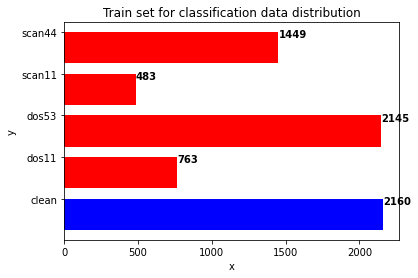

In [65]:
x = ["clean","dos11","dos53","scan11","scan44"]
y = np.unique(Y_train_classification, return_counts=True)[1]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color=["blue","red","red","red", "red"])
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title("Train set for classification data distribution")
plt.xlabel("x")
plt.ylabel("y")      
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color="black", fontweight="bold")
plt.savefig(os.path.join("Train_classification.png"), dpi=300, format="png", bbox_inches="tight")

In [66]:
def plot_images(images, labels, predictions=None, class_names=None):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='gray')
        
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[int(labels[i])])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[int(labels[i,0])], class_names[int(predictions[i].argmax())])
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

**LABELS:**<br>
clean = 0, <br>
dos11 = 1,<br>
dos53 = 2,<br>
scan11 = 3,<br>
scan44 = 4.<br>

In [67]:
#define the classes
label_ids = {'Clean': 0, 'dos11': 1, 'dos53': 2, 'scan11': 3, 'scan44': 4}

# Number of classes
num_classes = 5

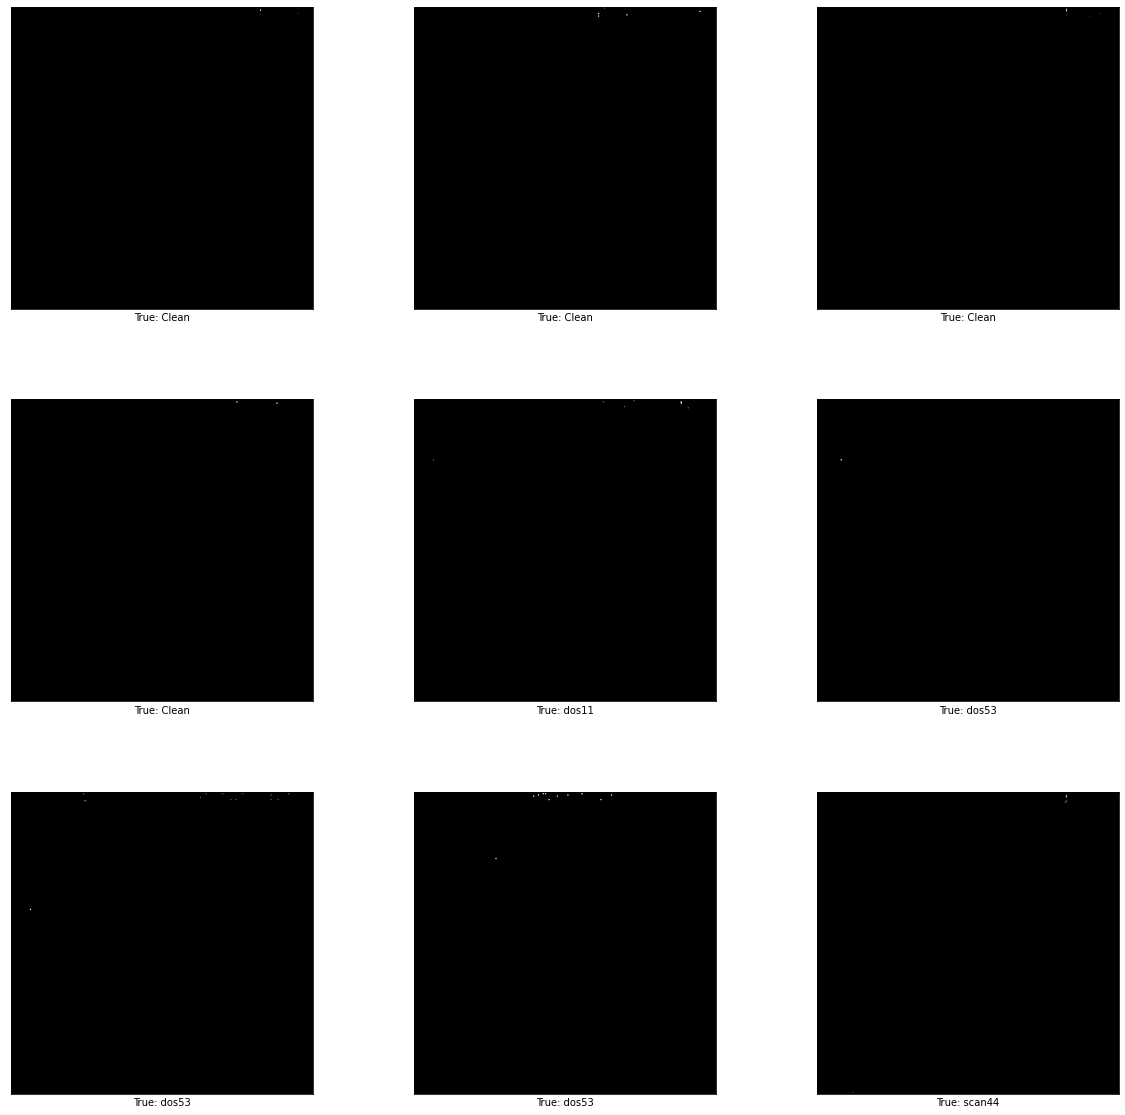

In [68]:
class_names = {value:key for key, value in label_ids.items()}
plot_images(
    X_train_classification[[1,700,1400,2100,2800,3500,4200,4900,5600]],
    Y_train_classification[[1,700,1400,2100,2800,3500,4200,4900,5600]],
    predictions=None,
    class_names=class_names
)

In [69]:
#shuffle sets using the shuffle function from sklearn (provided above)
train_images, train_labels = shuffle(X_train_classification, Y_train_classification, random_state=0)


In [70]:
# Number of samples and size of one of the image dimension (images are squared)
num_samples = len(X_train_classification)
img_shape = X_train_classification.shape

print(img_shape)

(7000, 256, 256, 1)


In [ ]:
model = Sequential([
    Conv2D(32, 3, strides=2, padding="same", activation="relu", input_shape=(256,256,1)),
    Conv2D(16, 3, strides=2, padding="same", activation="relu"),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(5, activation = "softmax"),
])

In [71]:
if(not LOAD_CLASSIFICATOR):
  
  #definition of the callback function
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max")

  history = model.fit(train_images, train_labels, 
                      batch_size = BATCH_SIZE , epochs = N_EPOCHS_C, validation_split = 0.2,
                      callbacks = [early_stopping])
  
  model.save("CLASSIFICATOR_model")
  np.save("CLASSIFICATOR_history.npy", history.history)
  print(output.OKGREEN+"Classificator saved"+output.END)

else:

  !gdown --id 15EdZ-DjlQJWQp0TcIAXt5EaPG3dRAeKF #CLASSIFICATOR_model.zip
  !gdown --id 1gRQL4pM5yHiXiVCURGbMKpAhhTRjyUeW #CLASSIFICATOR_history.npy

  !unzip CLASSIFICATOR_model.zip

  model = keras.models.load_model("content/CLASSIFICATOR_model")



  history = np.load("CLASSIFICATOR_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Classificator loaded"+output.END)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15EdZ-DjlQJWQp0TcIAXt5EaPG3dRAeKF
To: /content/CLASSIFICATOR_model.zip
100% 42.0M/42.0M [00:00<00:00, 67.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gRQL4pM5yHiXiVCURGbMKpAhhTRjyUeW
To: /content/CLASSIFICATOR_history.npy
100% 686/686 [00:00<00:00, 1.08MB/s]
Archive:  CLASSIFICATOR_model.zip
   creating: content/CLASSIFICATOR_model/
  inflating: content/CLASSIFICATOR_model/saved_model.pb  
   creating: content/CLASSIFICATOR_model/assets/
  inflating: content/CLASSIFICATOR_model/ke

In [72]:
if(DOWNLOAD_CLASSIFICATOR_MODEL):

  !zip -r /content/CLASSIFICATOR_model.zip /content/CLASSIFICATOR_model
  
  if(GOOGLE_DRIVE):

    !cp CLASSIFICATOR_model.zip /content/drive/MyDrive
    !cp CLASSIFICATOR_history.npy /content/drive/MyDrive

  else:

    files.download("CLASSIFICATOR_model.zip")
    files.download("CLASSIFICATOR_history.npy")

  print(output.OKGREEN+"Classificator downloaded to local memory"+output.END)
  !rm CLASSIFICATOR_model.zip

In [73]:
# shuffle sets
test_images, test_labels = shuffle(X_test_matrix, Y_test, random_state=0)

In [79]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("TEST ACCURACY: " +str(test_acc*100)+"%")

94/94 [==============================] - 1s 13ms/step - loss: 0.5445 - accuracy: 0.9033
TEST ACCURACY: 90.3333306312561%


In [75]:
def plot_images(images, labels, predictions=None, class_names=None):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='gray')
        
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[int(labels[i])])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[int(labels[i])], class_names[int(predictions[i].argmax())])
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.

    plt.show()

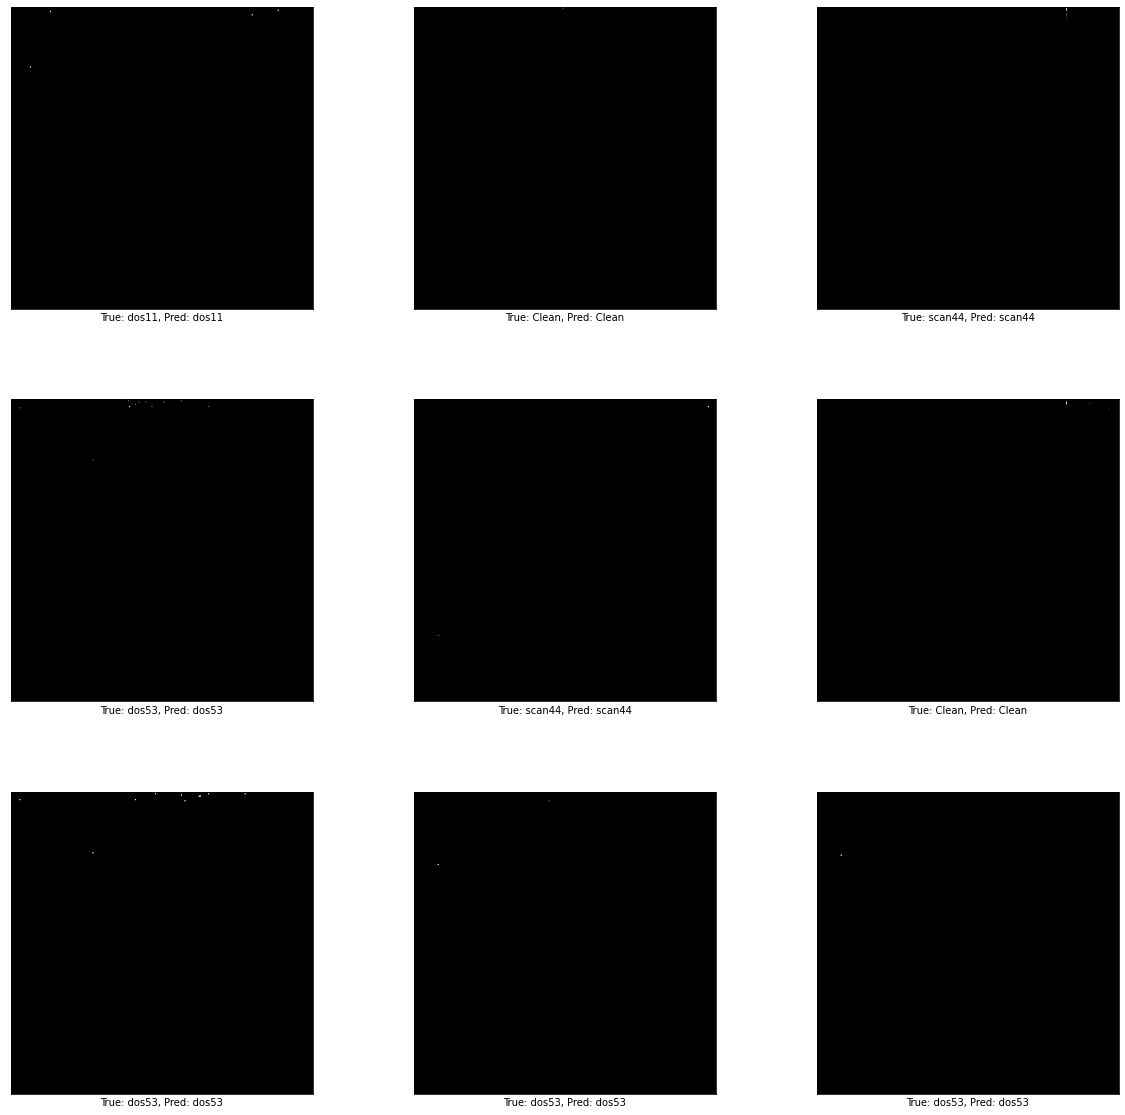

In [76]:
plot_images(images=test_images[[1, 300, 600, 900, 1200, 1500, 1800,2100,2400]], labels=test_labels[[1, 300, 600, 900, 1200, 1500, 1800,2100,2400]],
            predictions=model.predict(test_images[[1, 300, 600, 900, 1200, 1500, 1800,2100,2400]]), class_names = class_names)

In [77]:
def print_confusion_matrix_pandas(model, images, labels):
    num_classes = 5
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=np.argmax(predictions,axis=1))
    # Plot the confusion matrix as an image.
    class_names = label_ids.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    #plt.axis([-0.5, 13.5, 13.5, -0.5])
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.savefig("confusion_matrix.png")
    plt.show()

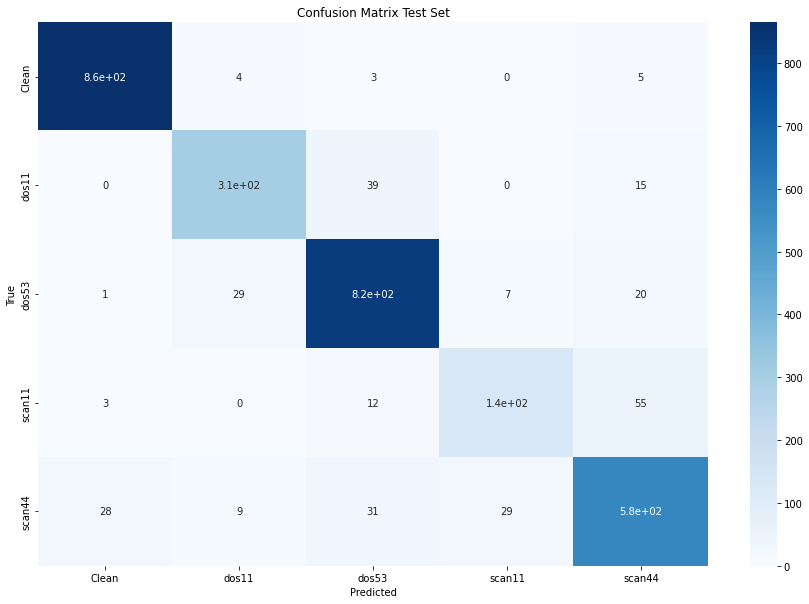

In [78]:
print_confusion_matrix_pandas(model, test_images, test_labels)